In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

Using cupy


In [2]:
@dataclass
class Config:
    nx: int = 800
    ny: int = 400
    steps: int = 10000
    output_stride: int = 200
    molecular_weights: tuple[float, float, float] = (28.0, 2.0, 44.0)  # N2, H2, CO2
    # Left half: 50% N2 + 50% H2, Right half: 50% N2 + 50% CO2
    left_frac: tuple[float, float, float] = (0.5, 0.25, 0.35) # pressure fraction
    right_frac: tuple[float, float, float] = (0.5, 0.35, 0.25)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 2
    frames_dir: str = "demo_frames/three_species_mixing"

In [3]:
def initialise_chamber(config: Config):
    nx, ny = config.nx, config.ny
    species = 3
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float64)
    mid = nx // 2
    left = xp.array(config.left_frac, dtype=xp.float64) * config.total_pressure
    right = xp.array(config.right_frac, dtype=xp.float64) * config.total_pressure
    for s in range(species):
        psigma[s, :mid, :] = left[s]
        psigma[s, mid:, :] = right[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [4]:
def _to_numpy(arr):
    if cp is not None and hasattr(cp, "asnumpy") and isinstance(arr, cp.ndarray):
        return cp.asnumpy(arr)
    return np.asarray(arr)

In [5]:
def save_concentration_frames(f: np.ndarray, phi: np.ndarray, frame_idx: int, out_dir: Path, molecular_weights) -> None:
    rho_s, _, _, rho_mix, _ = calculate_moment(f, phi)
    rho_mix_safe = xp.where(rho_mix > 0.0, rho_mix, 1.0)
    conc = rho_s #/ rho_mix_safe[None, :, :]

    conc_cpu = _to_numpy(conc)
    mw_cpu = _to_numpy(molecular_weights)
    labels = ["N2", "H2", "CO2"]
    cmaps = ["Blues", "Greens", "Reds"]

    fig, axes = plt.subplots(3, 1, figsize=(6, 9), sharex=True, sharey=True)
    for s in range(3):
        #im = axes[s].imshow((conc_cpu[s].T)/mw_cpu[s], origin="lower", cmap=cmaps[s], aspect="auto")
        im = axes[s].imshow((conc_cpu[s].T), origin="lower", cmap=cmaps[s], aspect="auto")
        axes[s].set_title(f"{labels[s]} concentration")
        axes[s].set_xlabel("x")
        axes[s].set_ylabel("y")
        fig.colorbar(im, ax=axes[s], fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(f"demo_frames_triple/frame_{frame_idx:04d}.png", dpi=160)
    plt.close(fig)

In [6]:
def main():
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)

    for step in tqdm(range(cfg.steps + 1)):
        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, out_dir, molecular_weights)
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream, step)
        #f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream)

    print(f"Saved frames to {out_dir}")

  0%|          | 0/10001 [00:00<?, ?it/s]

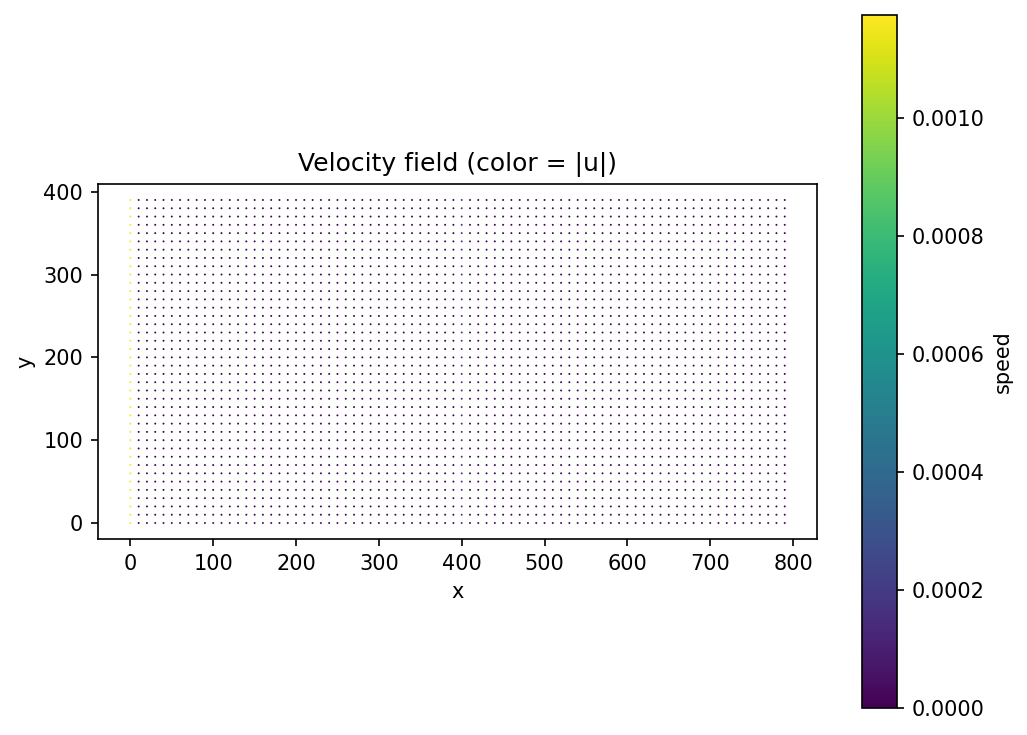

  2%|▏         | 197/10001 [00:07<05:14, 31.13it/s]

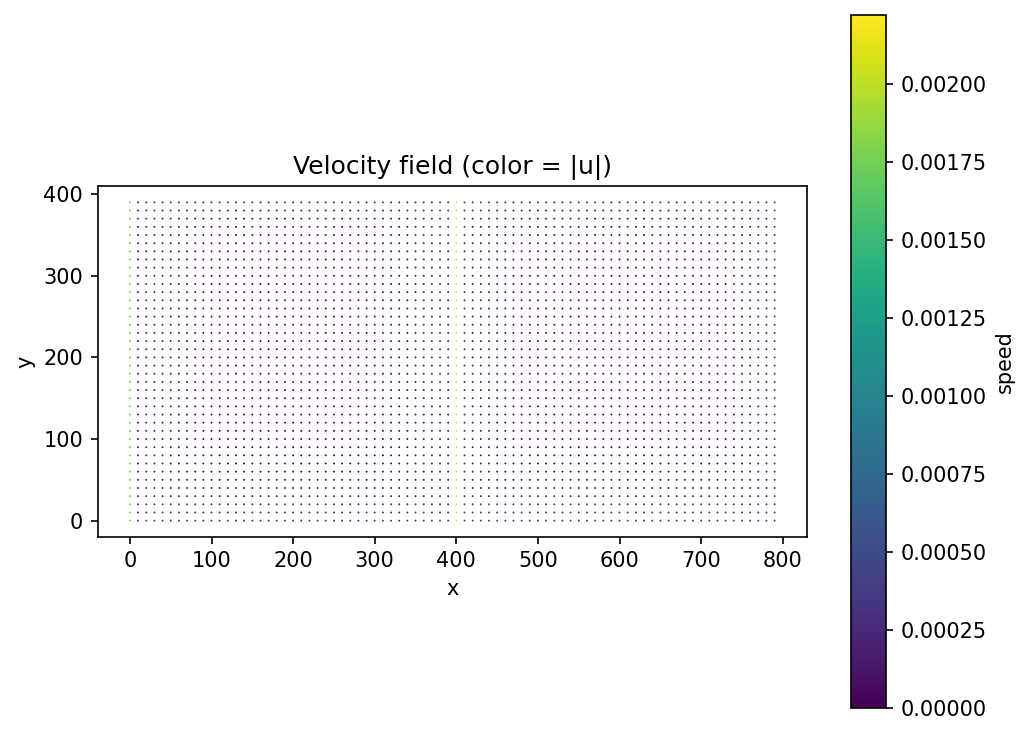

  4%|▍         | 399/10001 [00:14<05:23, 29.64it/s]

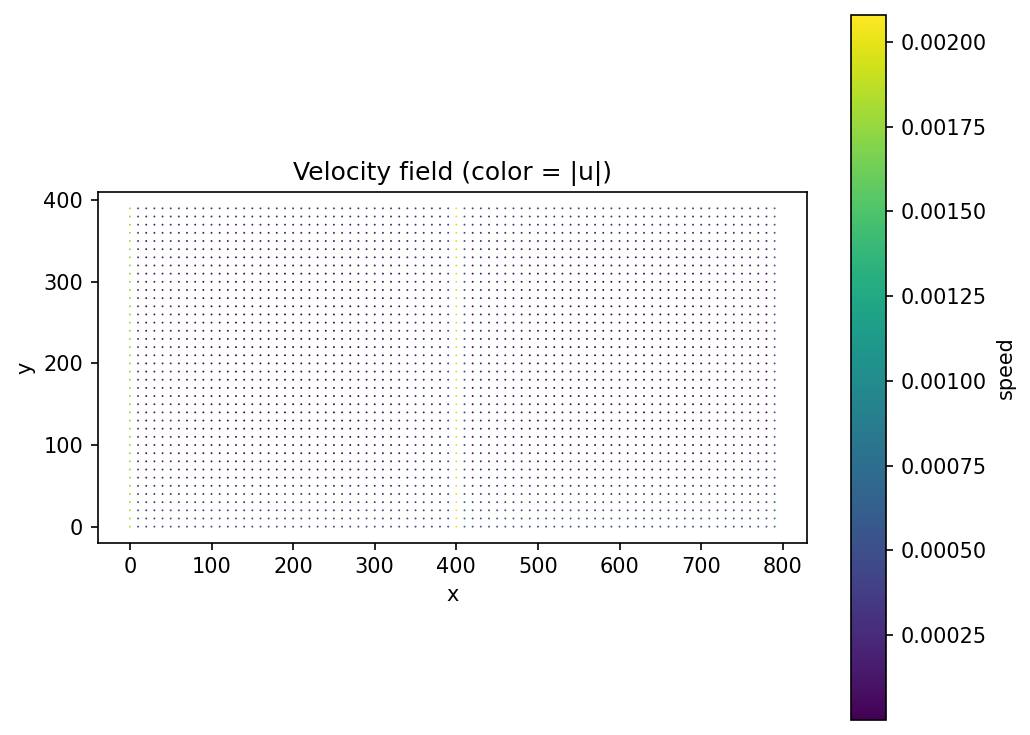

  6%|▌         | 599/10001 [00:22<05:01, 31.19it/s]

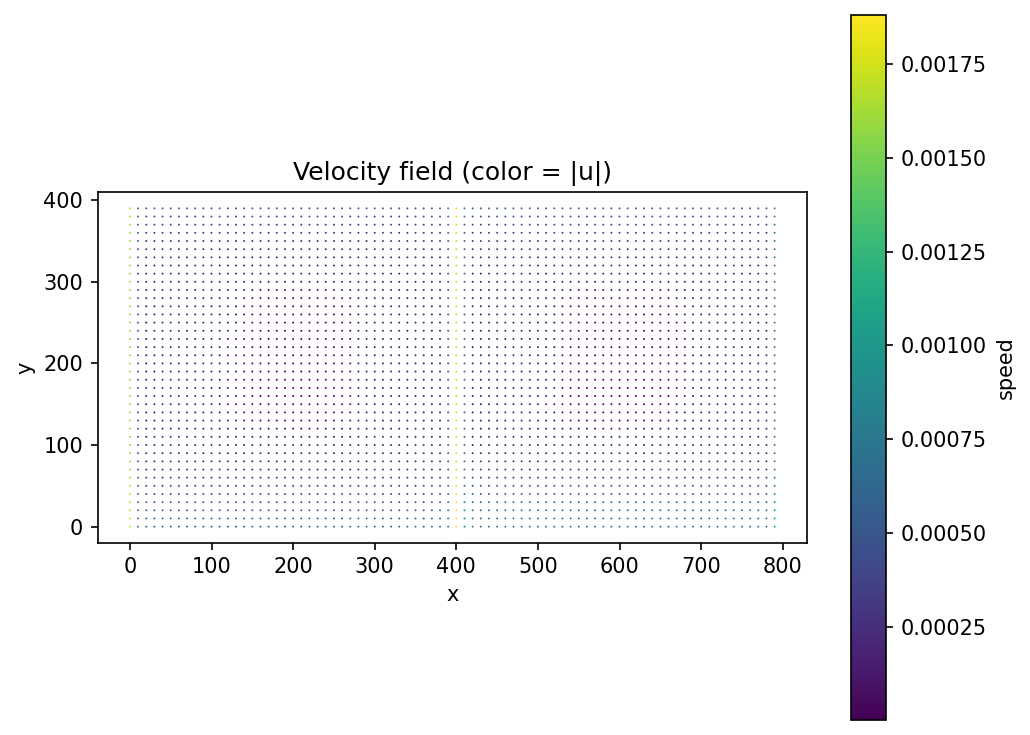

  8%|▊         | 799/10001 [00:29<05:58, 25.70it/s]

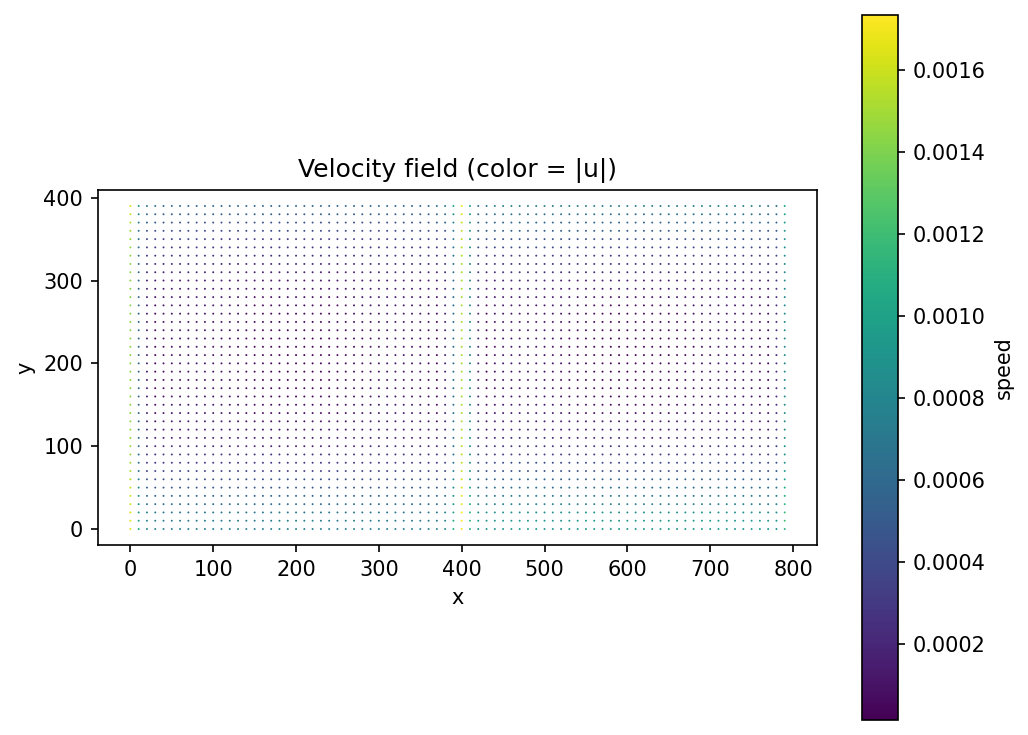

 10%|▉         | 997/10001 [00:37<04:49, 31.05it/s]

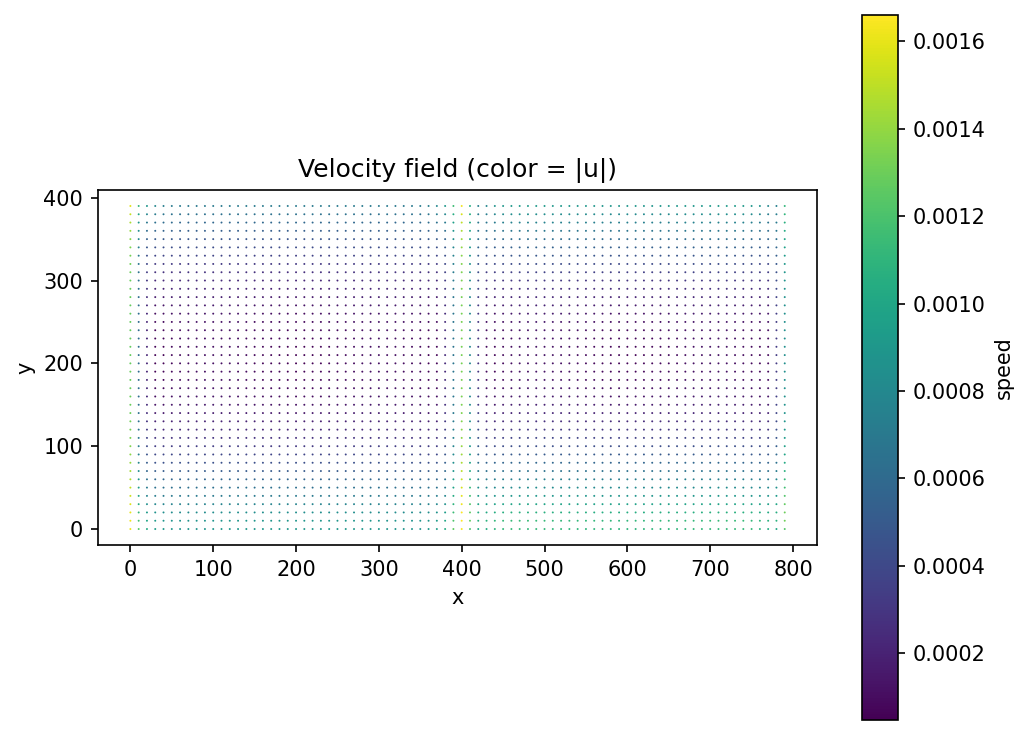

 12%|█▏        | 1197/10001 [00:44<04:42, 31.17it/s]

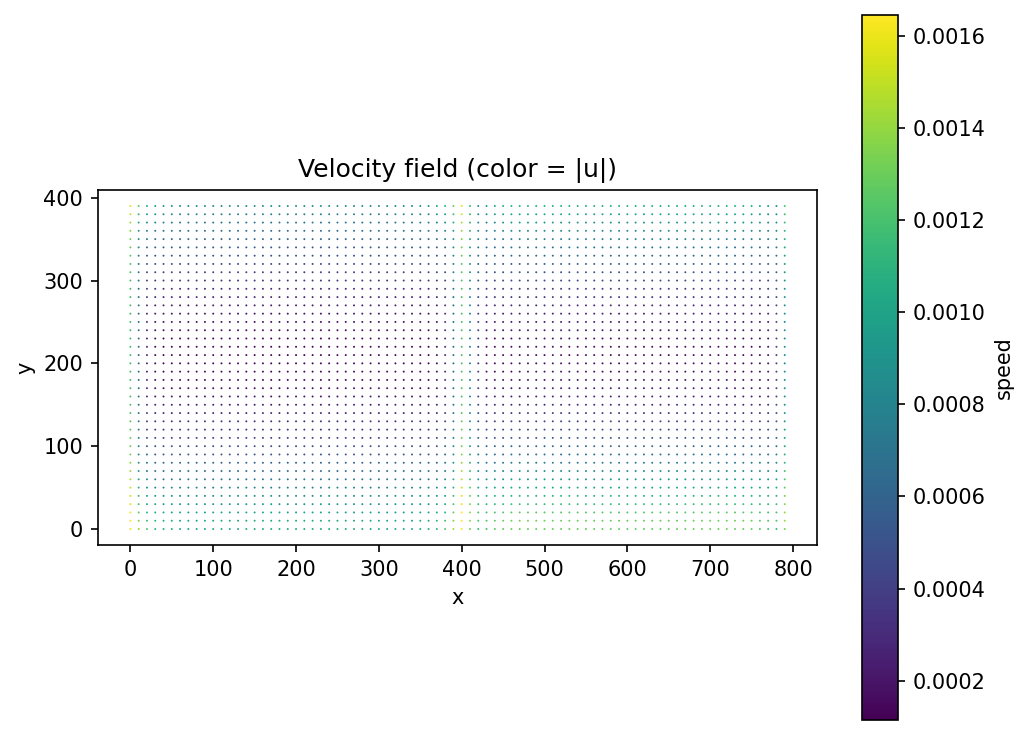

 14%|█▍        | 1399/10001 [00:51<04:33, 31.47it/s]

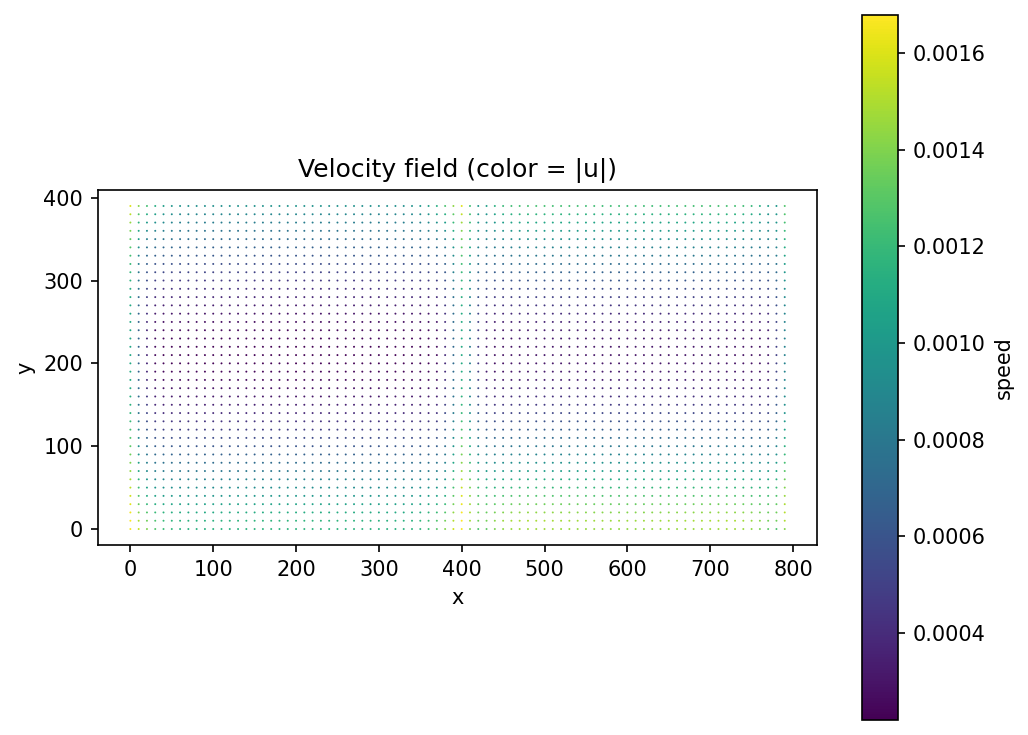

 16%|█▌        | 1598/10001 [00:59<04:27, 31.40it/s]

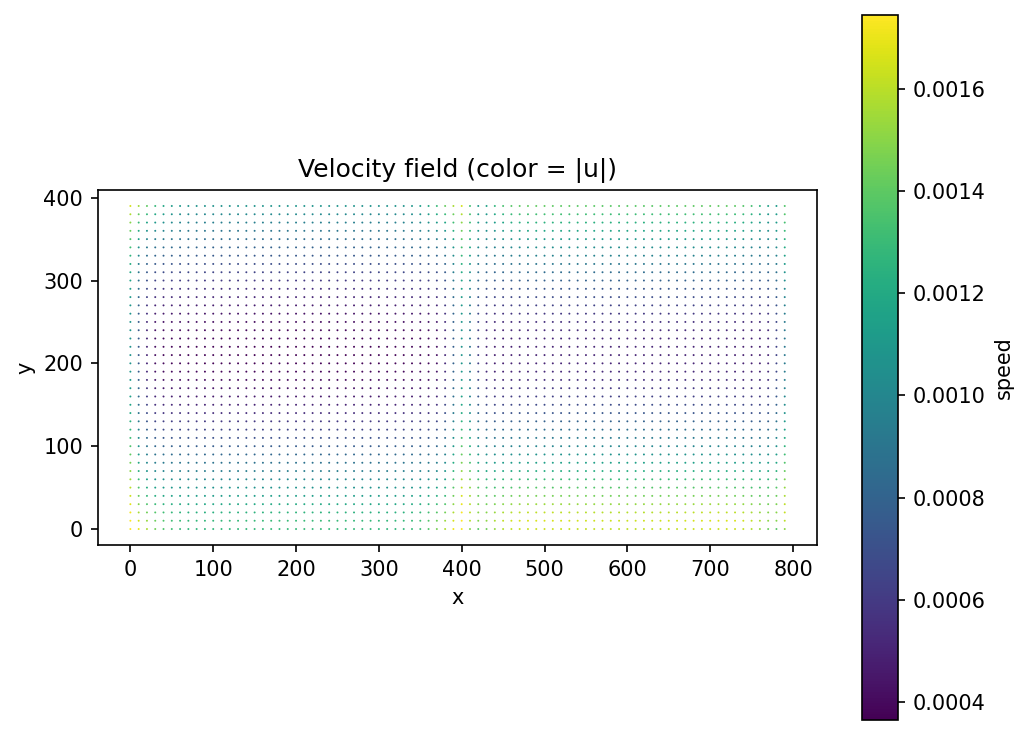

 18%|█▊        | 1798/10001 [01:07<04:17, 31.83it/s]

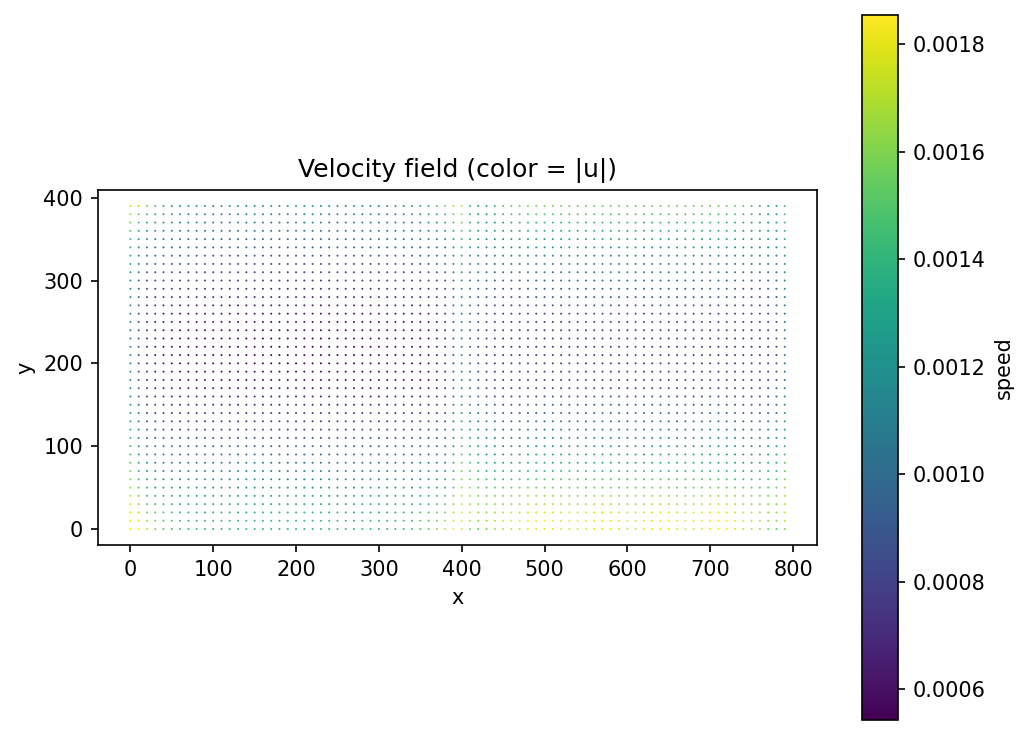

 20%|█▉        | 1999/10001 [01:14<04:12, 31.75it/s]

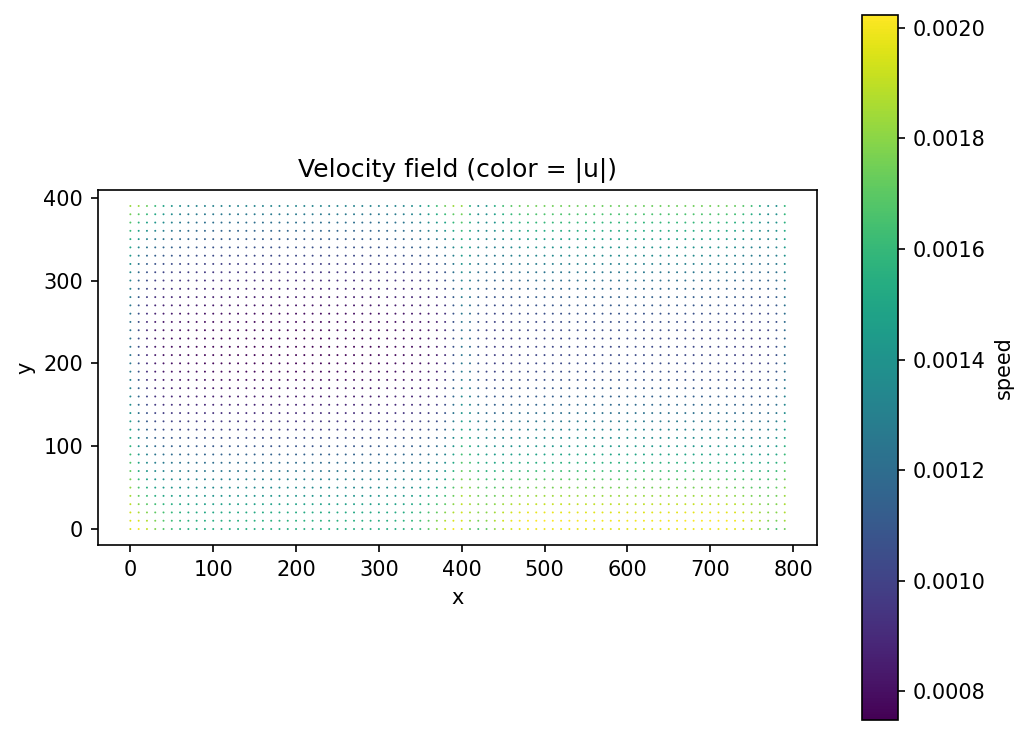

 22%|██▏       | 2198/10001 [01:22<04:05, 31.83it/s]

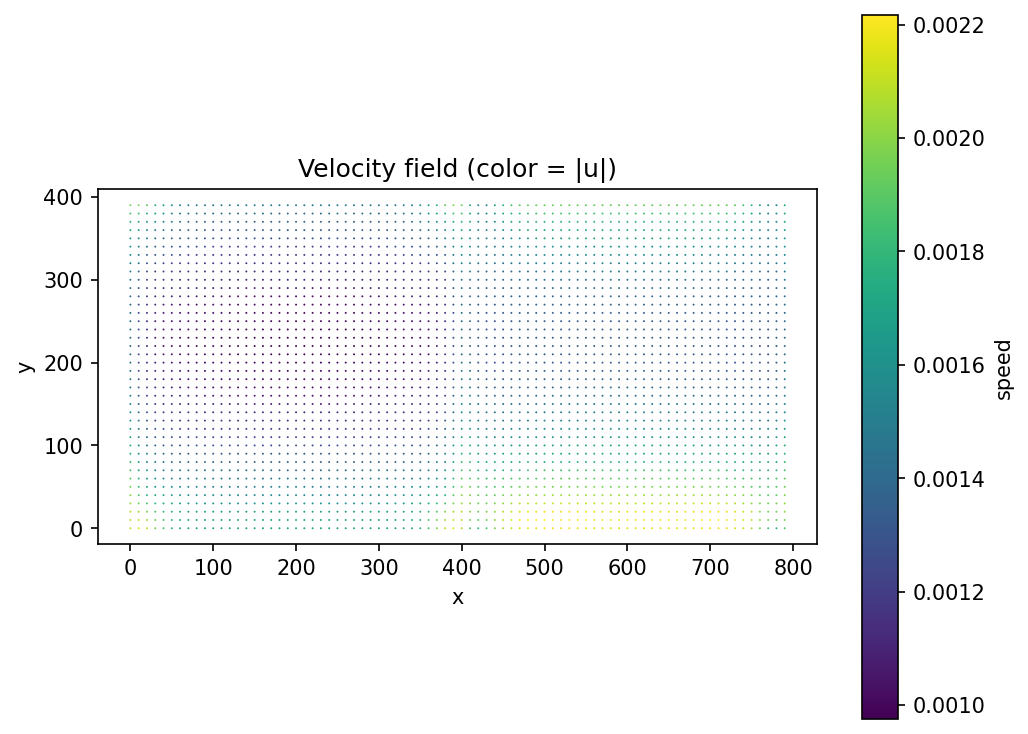

 24%|██▍       | 2399/10001 [01:29<03:56, 32.19it/s]

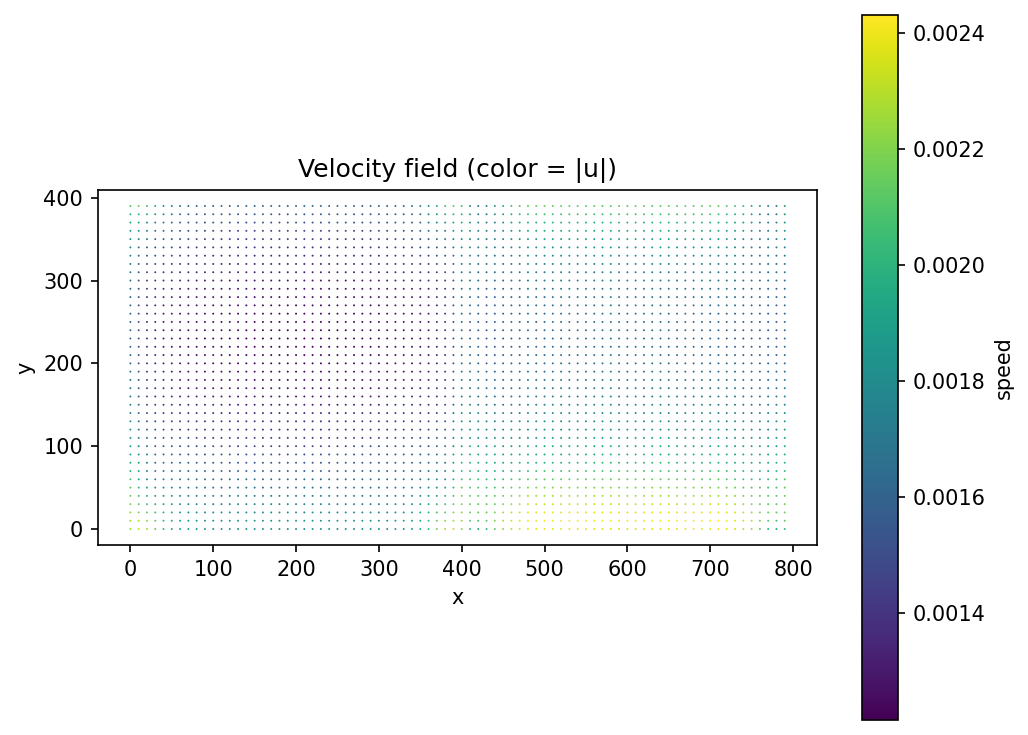

 26%|██▌       | 2598/10001 [01:37<03:53, 31.66it/s]

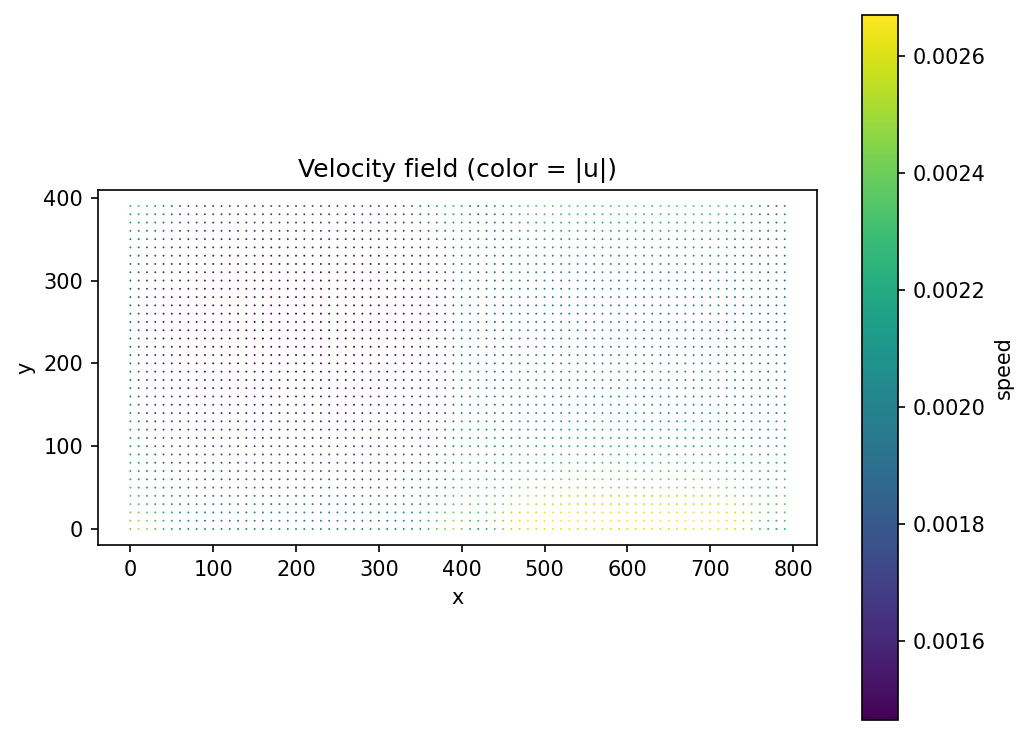

 28%|██▊       | 2799/10001 [01:44<03:46, 31.83it/s]

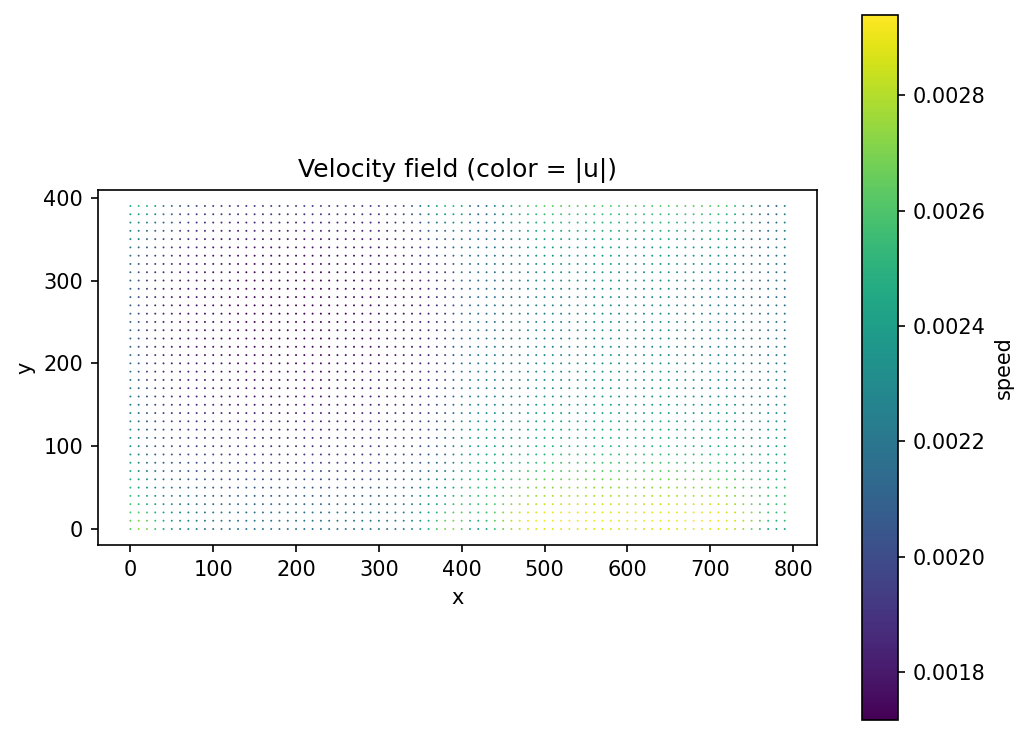

 29%|██▉       | 2917/10001 [01:49<04:25, 26.65it/s]


KeyboardInterrupt: 

In [7]:
%prun -D mslbm.pstat main()